In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


from layers.embedding import EmbeddingLayer
from layers.rnn.bidirectionalRNN import BidirectionalRNN
from layers.rnn.unidirectionalRNN import UnidirectionalRNN
from layers.dropout import DropoutLayer
from layers.dense import DenseLayer

from something.model import Model
from something.rnn import RNN
from utils.evaluate import evaluate_model

from sklearn.metrics import f1_score
import random

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/valid.csv')
train['label'] = train['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
test['label'] = test['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)
valid['label'] = valid['label'].map({'neutral': 0, 'positive': 1, 'negative': 2}).astype(np.float32)

# Set random seed for reproducibility
seed = 42
random.seed(seed)                         # python random
np.random.seed(seed)                      # numpy
tf.random.set_seed(seed)   

In [6]:
tokenizer = Tokenizer(oov_token="<UNK>")  # Reserve a token for unknown words
tokenizer.fit_on_texts(train['text'].values) 
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2796


In [7]:
embedding_dim = 50 # Dimension of the embedding layer
max_length = 60  # Maximum length of input sequences

train_sequences = tokenizer.texts_to_sequences(train['text'].values)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
valid_sequences = tokenizer.texts_to_sequences(valid['text'].values)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = tokenizer.texts_to_sequences(test['text'].values)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (index 0 is reserved)

95th Percentile Length: 54.0
98th Percentile Length: 59.0


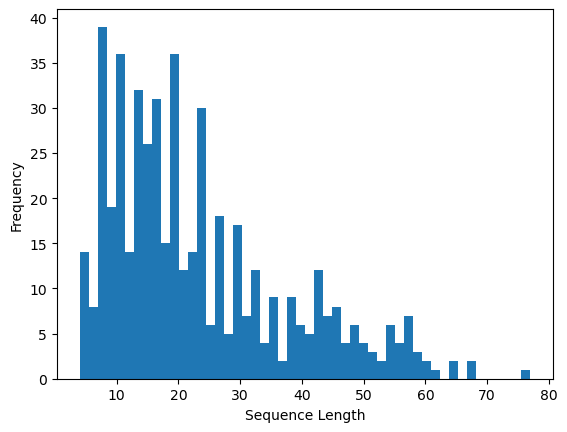

In [8]:
import matplotlib.pyplot as plt
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train['text'].values)]
percentile_95 = np.percentile(lengths, 95)
percentile_98 = np.percentile(lengths, 98)
print(f"95th Percentile Length: {percentile_95}")
print(f"98th Percentile Length: {percentile_98}")
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

In [9]:
print(f"Train padded shape: {train_padded.shape}")
print(f"Valid padded shape: {valid_padded.shape}")
print(f"Test padded shape: {test_padded.shape}")

Train padded shape: (500, 60)
Valid padded shape: (100, 60)
Test padded shape: (400, 60)


In [21]:
def get_weights_per_layer(model, verbose=True):
    all_weights = []
    for layer in model.layers:
        if verbose:
            print(f"Layer: {layer.name}") 
        weights = layer.get_weights()
        all_weights.append(weights)
        if verbose:
            for i, w in enumerate(weights):
                print(f"  Weight {i}: shape {w.shape}")
    return all_weights

# Pengaruh Jumlah Layer

In [31]:
val_loss = []
train_loss = []

## 1 layer RNN

In [32]:
# Build the model
layer1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer1.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

val_loss_1 = history.history['val_loss']
val_train_1 = history.history['loss']
train_loss.append(val_train_1)
val_loss.append(val_loss_1)

all_weights = get_weights_per_layer(layer1, verbose=False)


# Evaluate the model
evaluate_model(layer1, test_padded, test['label'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Macro F1 Score: 0.4460


In [33]:
layer1Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer1Scratch.load_weights(all_weights)

# Evaluate the model
evaluate_model(layer1Scratch, test_padded, test['label'])

Macro F1 Score: 0.4460


## 2 Layer RNN

In [34]:
# Build the model
layer2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer2.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

val_loss_2 = history.history['val_loss']
val_train_2 = history.history['loss']
train_loss.append(val_train_2)
val_loss.append(val_loss_2)

all_weights = get_weights_per_layer(layer2, verbose=False)

# Evaluate the model
evaluate_model(layer2, test_padded, test['label'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Macro F1 Score: 0.4739


In [38]:
layer2Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer2Scratch.load_weights(all_weights)

# Evaluate the model
evaluate_model(layer2Scratch, test_padded, test['label'])

Macro F1 Score: 0.4739


## 3 Layer RNN


In [39]:
# Build the model
layer3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=True),
    SimpleRNN(units=8, activation='tanh', return_sequences=False),
    # Dropout(0.5),
    Dense(3, activation='softmax')  # for binary classification (e.g., sentiment)
])

# Compile the model
layer3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = layer3.fit(
    train_padded,
    train['label'].values,
    validation_data=(valid_padded, valid['label'].values),
    epochs=10,          # number of passes over the data, adjust as needed
    batch_size=32,      # number of samples per batch, adjust as needed
    verbose=0          # verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)

val_loss_2 = history.history['val_loss']
val_train_2 = history.history['loss']
train_loss.append(val_train_2)
val_loss.append(val_loss_2)

all_weights = get_weights_per_layer(layer3, verbose=False)

# Evaluate the model
evaluate_model(layer3, test_padded, test['label'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Macro F1 Score: 0.3689


In [41]:
layer3Scratch = RNN([
    EmbeddingLayer(vocab_size, embedding_dim),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=True, activation='tanh'),
    UnidirectionalRNN(8, return_sequences=False, activation='tanh'),
    # DropoutLayer(0.5),
    DenseLayer(3, 8, activation='softmax', init_method='zeros')
], 32)

layer3Scratch.load_weights(all_weights)

# Evaluate the model
evaluate_model(layer3Scratch, test_padded, test['label'])

Macro F1 Score: 0.3689
